<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Installation of Libraries </h1>

In [1]:
#!pip install -q evaluate

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Download Dataset from External Source </h1>

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Importing Libraries </h1>

In [2]:
import warnings
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#os.environ["KERAS_BACKEND"] = "tensorflow"
warnings.filterwarnings('ignore')

In [3]:
import pathlib
import datetime
import random
import zipfile
import shutil
import re
import string
from ast import literal_eval

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import  metrics
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import ops
from tensorflow.keras import regularizers
from tensorflow.keras import applications
from tensorflow.keras  import preprocessing
from tensorflow.keras import datasets

import transformers 
from datasets import load_dataset

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import tensorflow_hub as hub
import keras_nlp
import tensorflow_datasets as tfds


#import evaluate


print("Importing libraries completed.")

Importing libraries completed.


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# n_gpu = torch.cuda.device_count()
# torch.cuda.get_device_name(0)

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Custom Functions </h1>

In [6]:
# Configuration
class Config:
    fine_tune = False
    manual_categorical= False
    save_model = False
    batch_size = 32
    epochs = 10
    data_source = 'keras' # url, tfds, kaggle, huggingface, keras
    data_format = 'none' # csv, folder, none
 


In [7]:
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)

    # Seed value for NumPy
    np.random.seed(seed)

    # Seed value for Python's random library
    random.seed(seed)

    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)


seed_everything()
print('Seeding completed')

Seeding completed


<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Reading Data </h1>

In [8]:
def from_tfds(dataname='imdb_reviews'):
    imdb_train, imdb_test = tfds.load(
      dataname,
      split=["train", "test"],
      as_supervised=True,
      batch_size=Config.batch_size,
    )
    return imdb_train, imdb_test

def from_huggingface(dataname='SetFit/go_emotions'):
    train_ds, test_ds = load_dataset(dataname, split=['train[:5000]', 'test[:2000]'])
    return train_ds, test_ds
    
def from_file(url):
    dataset = tf.keras.utils.get_file(origin=url, untar=False, cache_dir='.', cache_subdir='')
    #dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

    return dataset

def from_kaggle(path):
    return path, os.listdir(path)

def from_keras():
    vocab_size = 20000  # Only consider the top 20k words
    maxlen = 200  # Only consider the first 200 words of each movie review
    (x_train, y_train), (x_val, y_val) = datasets.imdb.load_data(num_words=vocab_size)
    
    x_train = utils.pad_sequences(x_train, maxlen=maxlen)
    x_val = utils.pad_sequences(x_val, maxlen=maxlen)
    
    return (x_train, y_train), (x_val, y_val) 

In [9]:
if Config.data_source == 'url':
    print('Dataset From File \n')
    dataset_dir = from_file("https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv")
    print(dataset_dir)
    #print(os.listdir(dataset_dir))

if Config.data_source == 'tfds':
    print('Dataset From Tensorflow \n')
    ds_train, ds_test =  from_tfds(dataname='imdb_reviews')

if Config.data_source == 'huggingface':
    print('Dataset From HuggingFace \n')
    ds_train, ds_test = from_huggingface(dataname='imdb')

if Config.data_source == 'kaggle':
    print('Dataset From Kaggle \n')
    dataset_dir, content = from_kaggle('/kaggle/input/pubmed-multilabel-text-classification')
    print(content)

if Config.data_source == 'keras':
    print('Dataset From Keras \n')
    (x_train, y_train), (x_val, y_val)  = from_keras()
    

Dataset From Keras 

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Data Inspection </h1>

In [10]:
# train_dir = os.path.join(dataset_dir, 'train')
# test_dir = os.path.join(dataset_dir, 'test')
# train_dir

In [11]:
if Config.data_format == 'csv':
    train_dir = 'PubMed Multi Label Text Classification Dataset Processed.csv'
    data_direction = os.path.join(dataset_dir, train_dir )
    dataset = pd.read_csv(data_direction ,encoding='ISO-8859-1')
    #test_dataset = pd.read_csv(test_dir ,encoding='ISO-8859-1')



<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Data Visualization </h1>

In [12]:
if Config.data_format == 'folder':
    sample = os.listdir(os.path.join(train_dir, 'pos'))[0]
    sample_file = os.path.join(train_dir, 'pos', sample)
    with open(sample_file) as f:
      display(f.read())

if Config.data_format == 'csv':
   display(dataset.head())
   print(f"There are {len(dataset)} rows in the dataset.") 

In [14]:
if Config.data_format == 'csv':
    cols = dataset.columns.to_list()
    labels = cols[6:]
    num_labels = len(labels)
    print('Labels:',labels)
    print("\n")
    print('Number of Labels: ' ,num_labels)
    print("\n")
    print("Duplicated values in the label column", dataset[labels].duplicated().sum(axis=0))

if Config.data_source == 'huggingface':
    display(ds_test[0])

# if Config.data_format == 'none':
#     display(ds_train)

In [15]:
%%time

if Config.data_format == 'csv':
    counts = []
    for item in labels:
        counts.append((item, dataset[item].sum()))
    df_count = pd.DataFrame(counts, columns=['Root Label', 'number of Abstract'])
    display(df_count)

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 11 µs


In [16]:
if Config.data_format == 'csv':
    sns.set(font_scale = 1)
    #plt.figure(figsize=(16,9))
    #ax= sns.barplot(labels,  dataset.iloc[:,6:].sum().values)
    plt.title("Each Root Class", fontsize=22)
    plt.ylabel('Number of Articles', fontsize=18)
    plt.xlabel('Root Label ', fontsize=18)
    
    #adding the text labels
    # rects = ax.patches
    block_labels = dataset.iloc[:,6:].sum().values
    # for rect, label in zip(rects, block_labels):
    #     height = rect.get_height()
    #     ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)
    
    #plt.show()

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Data Preprocessing </h1>

In [17]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [18]:
if Config.data_format == 'csv':
   

    # dataset = dataset[~dataset["titles"].duplicated()]
    # print(f"There are {len(dataset)} rows in the deduplicated dataset.")
    
    # # There are some terms with occurrence as low as 1.
    # print(sum(dataset["terms"].value_counts() == 1))
    
    # # How many unique terms?
    # print(dataset["terms"].nunique())
    pass 

In [19]:
if Config.data_format == 'csv':
    dataset_filtered = dataset
    # dataset_filtered = dataset.groupby("terms").filter(lambda x: len(x) > 1)
    display(dataset_filtered.shape)
     

In [20]:
# Convert the string labels to lists of strings
if Config.data_format == 'csv':
    # dataset_filtered["terms"] = dataset_filtered["terms"].apply(
    # lambda x: literal_eval(x))
    # display(dataset_filtered["terms"].values[:2])
    pass

In [21]:
if Config.data_format == 'csv':
    test_split = 0.1

    # Initial train and test split.
    train_ds, test_ds = train_test_split(
        dataset_filtered,
        test_size=test_split,
        random_state=32,
        #stratify=dataset_filtered["terms"].values,
    )
    
    # Splitting the test set further into validation
    # and new test sets.
    val_ds = test_ds.sample(frac=0.5)
    test_ds.drop(val_ds.index, inplace=True)
    
    print(f"Number of rows in training set: {len(train_ds)}")
    print(f"Number of rows in validation set: {len(val_ds)}")
    print(f"Number of rows in test set: {len(test_ds)}")

In [22]:
if Config.data_format == 'csv':
    train_ds['one_hot_labels'] = list(train_ds[labels].values)
    display(train_ds.head(3))

In [23]:
# raw_train_ds = tf.keras.utils.text_dataset_from_directory(
#     train_dir,
#     batch_size=Config.batch_size,
#     validation_split=0.2,
#     subset='training',
#     seed=42
# )


In [24]:
# raw_val_ds = tf.keras.utils.text_dataset_from_directory(
#     train_dir,
#     batch_size=Config.batch_size,
#     validation_split=0.2,
#     subset='validation',
#     seed=42
# )

In [25]:
# raw_test_ds = tf.keras.utils.text_dataset_from_directory(
#     test_dir,
#     batch_size=Config.batch_size
# )

In [26]:
if Config.data_source == 'tfds':
    train_dataset = imdb_train.take(250)
    val_dataset = imdb_test.take(250)
    

In [27]:
if Config.data_source == 'huggingface':
    tokenizer = transformers .AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
    tokenized_ds_train = ds_train.map(preprocess_function, batched=True)
    tokenized_ds_test = ds_test.map(preprocess_function, batched=True)

<h1 id="ergdfffggs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center"> Data Postprocessing </h1>

In [28]:
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [29]:
if Config.data_format == 'csv':
    # terms = tf.ragged.constant(train_ds["terms"].values)
    # lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
    # lookup.adapt(terms)
    # vocab = lookup.get_vocabulary()
    # print("Vocabulary:\n")
    # print(vocab)

    # sample_label = train_ds["terms"].iloc[0]
    # print(f"Original label: {sample_label}")

    # label_binarized = lookup([sample_label])
    # print(f"Label-binarized representation: {label_binarized}")

    # train_ds["summaries"].apply(lambda x: len(x.split(" "))).describe()
    pass


In [30]:
if Config.data_source == 'tfds':
    max_seqlen = 150
    batch_size = 128
    padding_token = "<pad>"
    auto = tf.data.AUTOTUNE


    train_dataset = make_dataset(train_ds, is_train=True)
    val_dataset = make_dataset(val_ds, is_train=False)
    test_dataset = make_dataset(test_ds, is_train=False)

    text_batch, label_batch = next(iter(train_dataset))

    for i, text in enumerate(text_batch[:5]):
        label = label_batch[i].numpy()[None, ...]
        print(f"Abstract: {text}")
        print(f"Label(s): {invert_multi_hot(label[0])}")
        print(" ")

In [31]:
if Config.data_source == 'tfds':
    vocabulary = set()
    train_ds["summaries"].str.lower().str.split().apply(vocabulary.update)
    vocabulary_size = len(vocabulary)
    print(vocabulary_size)

In [32]:
if Config.data_source == 'tfds':
    text_vectorizer = layers.TextVectorization(
        max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
    )

    # `TextVectorization` layer needs to be adapted as per the vocabulary from our
    # training set.
 
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [33]:
if Config.data_source == 'tfds':
    train_dataset = train_dataset.map(
        lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
    ).prefetch(auto)
    val_dataset = val_dataset.map(
        lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
    ).prefetch(auto)
    test_dataset = test_dataset.map(
        lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
    ).prefetch(auto)

In [34]:
# for text_batch, label_batch in raw_train_ds.take(1):
#   for i in range(3):
#     print("Review", text_batch.numpy()[i])
#     print("Label", label_batch.numpy()[i])

In [35]:
# print("Label 0 corresponds to", raw_train_ds.class_names[0])
# print("Label 1 corresponds to", raw_train_ds.class_names[1])

In [36]:
# def custom_standardization(input_data):
#   lowercase = tf.strings.lower(input_data)
#   stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
#   return tf.strings.regex_replace(stripped_html,
#                                   '[%s]' % re.escape(string.punctuation),
#                                   '')

In [37]:
# max_features = 20000
# sequence_length = 500

# vectorize_layer = layers.TextVectorization(
#     standardize=custom_standardization,
#     max_tokens=max_features,
#     output_mode='int',
#     output_sequence_length=sequence_length)

In [38]:
# # Make a text-only dataset (without labels), then call adapt
# train_text = raw_train_ds.map(lambda x, y: x)
# vectorize_layer.adapt(train_text)
# print('Vectorization Completed')

In [39]:
# def vectorize_text(text, label):
#   text = tf.expand_dims(text, -1)
#   return vectorize_layer(text), label

In [40]:
# # retrieve a batch (of 32 reviews and labels) from the dataset
# text_batch, label_batch = next(iter(raw_train_ds))
# first_review, first_label = text_batch[0], label_batch[0]
# print("Review", first_review)
# print("Label", raw_train_ds.class_names[first_label])
# print("Vectorized review", vectorize_text(first_review, first_label))

In [41]:
# print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
# print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
# print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

In [42]:
# train_ds = raw_train_ds.map(vectorize_text)
# val_ds = raw_val_ds.map(vectorize_text)
# test_ds = raw_test_ds.map(vectorize_text)

In [43]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_dataset = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_dataset = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
if Config.data_source == 'huggingface':
    data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [45]:
if Config.data_source == 'huggingface':
    accuracy = evaluate.load("accuracy")

In [46]:
if Config.data_source == 'huggingface':
    batch_size = 16
    num_epochs = 5
    batches_per_epoch = len(tokenized_ds_train) // batch_size
    total_train_steps = int(batches_per_epoch * num_epochs)
    optimizer, schedule = transformers.create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [47]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [48]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [49]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

<h1 id="ergdfffggs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center"> Model </h1>

### **Custom Model**

In [50]:
def make_model():
    embed_dim = 32  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer
    maxlen = 200 
    vocab_size = 20000
    
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(2, activation="softmax")(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [51]:
def custom_simple_model():
    embedding_dim = 16
    
    model = tf.keras.Sequential([
          layers.Embedding(max_features, embedding_dim),
          layers.Dropout(0.2),
          layers.GlobalAveragePooling1D(),
          layers.Dropout(0.2),
          layers.Dense(1, activation='sigmoid')])
    return model

In [52]:
def custom_advance_model():
    embedding_dim = 128 
    
    
    inputs = layers.Input(shape=(None,), dtype="int64")
    
    
    # Next, we add a layer to map those vocab indices into a space of dimensionality
    # 'embedding_dim'.
    x = layers.Embedding(max_features, embedding_dim)(inputs)
    x = layers.Dropout(0.5)(x)
    
    # Conv1D + global max pooling
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.GlobalMaxPooling1D()(x)
    
    # We add a vanilla hidden layer:
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    # We project onto a single unit output layer, and squash it with a sigmoid:
    predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)
    
    model = models.Model(inputs, predictions)

    return model

### **Fine Tuning Model**

In [53]:
def fine_tune_model(base_model):

    for layer in base_model.layers[:-15]:
        layer.trainable=True




### **Transfer Learning Model**

In [54]:
def transfer_model(input_shape, num_classes):

     pass

model_name='ResNet101'

### **Keras NLP**

In [55]:
def keras_nlp_model():
  classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_base_en_uncased",
    num_classes=2,
    activation="softmax",
  )
  return classifier

### **Transformers Model**

In [56]:
def transformers_model():
    input_ids = layers.Input(shape=(128,),dtype='int32')

    attention_masks = layers.Input(shape=(128,),dtype='int32')
    
    base_model = transformers.TFBertModel.from_pretrained('bert-base-uncased')

    embeddings = base_model([input_ids,attention_masks])[1]

    output = layers.Dense(3, activation="softmax")(embeddings)

    model = models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    return model

In [57]:
def simple_transformers_model():
    model = transformers.TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
    )
    return model

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Training </h1>

In [58]:
def run_experiment(cmodel):
    

    # cmodel.compile(
    #         loss= losses.SparseCategoricalCrossentropy(),
    #         optimizer=optimizers.AdamW(learning_rate=0.0005),
    #         metrics=[
    #             metrics.SparseCategoricalAccuracy(name="accuracy"),
    #             #metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    #         ],
    #     )
    if Config.data_source == 'huggingface':
        cmodel.compile(optimizer=optimizer)  
    else:
        cmodel.compile(
            loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    custom_callbacks = [
        #callbacks.ModelCheckpoint("/tmp/checkpoint.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1, save_weights_only=False),
        #callbacks.EarlyStopping(monitor='val_accuracy', patience=6, verbose=1, restore_best_weights=True),
        #callbacks.ReduceLROnPlateau(monitor='val_accuracy' , factor=0.3, patience=5,min_delta = 0.001, mode='auto', verbose=1),
        #callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]

    if Config.data_source == 'huggingface':
        metric_callback = transformers.keras_callbacks.KerasMetricCallback(
            metric_fn=compute_metrics, eval_dataset=val_dataset)
        custom_callbacks = [metric_callback]
        
    if Config.data_source == 'keras':
        history = cmodel.fit(
            x_train, 
            y_train, 
            batch_size=32, 
            epochs=Config.epochs, 
            validation_data=(x_val, y_val)
        )
        evaluation= cmodel.evaluate(x_val, y_val, return_dict=True)
    else:
        history = cmodel.fit(
            train_dataset,
            validation_data=val_dataset,
            
            epochs=Config.epochs,
            #initial_epoch=history_1.epoch[-1],
            #callbacks=custom_callbacks,
        )
        evaluation= cmodel.evaluate(val_dataset, return_dict=True)



    return history, cmodel, evaluation

In [59]:
#model = custom_simple_model()
#model = custom_advance_model()
model = make_model()
#model = keras_nlp_model()
#model = transformers_model()
#model = simple_transformers_model()

#utils.plot_model(model, show_shapes=True, dpi=50, show_layer_names=False, expand_nested=True, to_file='mobilenet.png')
#model.summary(show_trainable=True)
print('Model is ready to be used')

Model is ready to be used


In [60]:
if Config.data_source == 'huggingface':
    train_dataset = model.prepare_tf_dataset(
    tokenized_ds_train,
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
    )

    val_dataset = model.prepare_tf_dataset(
        tokenized_ds_test,
        shuffle=False,
        batch_size=16,
        collate_fn=data_collator,
    )

In [61]:
#with tf.device('/GPU:0'):
history, tmodel, evaluation  = run_experiment(model)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.7082 - loss: 0.5273 - val_accuracy: 0.8802 - val_loss: 0.2816
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9138 - loss: 0.2211 - val_accuracy: 0.8710 - val_loss: 0.3233
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9449 - loss: 0.1474 - val_accuracy: 0.8603 - val_loss: 0.3982
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9680 - loss: 0.0952 - val_accuracy: 0.8380 - val_loss: 0.5713
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9755 - loss: 0.0752 - val_accuracy: 0.8475 - val_loss: 0.6061
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9782 - loss: 0.0600 - val_accuracy: 0.8262 - val_loss: 0.8992
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9864 - loss: 0.0373 - val_accuracy: 0.8283 - val_loss: 1.0671
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9911 - loss: 0.0247 - val_accuracy: 

In [62]:
if Config.fine_tune:
    print('Fine tuning the model')
    fine_tune_model(base_model)
    history_finetune, fmodel, evaluation  = run_experiment(tmodel)
    tmodel = fmodel

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Evaluation </h1>

In [63]:
def read_metrics():
    metric_holder=[mertic for mertic in evaluation.keys() ]
    value_holder = [round(value,2)*100 for value in evaluation.values()]

    return pd.DataFrame({'Metrics':metric_holder, 'Value (%)': value_holder})

evals = read_metrics()
evals

,Metrics,Value (%)
0,accuracy,83.0
1,loss,127.0


In [64]:
def make_plot(metric, history):
  plt.plot(history.history[metric ], color='#8502d1')
  plt.plot(history.history['val_'+metric ], color='darkorange')
  plt.title( 'Model '+metric )
  plt.ylabel( metric.capitalize() )
  plt.xlabel( 'Epoch' )
  plt.legend([ 'Train' , 'Validation' ], loc='best' )
  #plt.savefig(model_name+'_'+metric+'.jpg')
  plt.show()


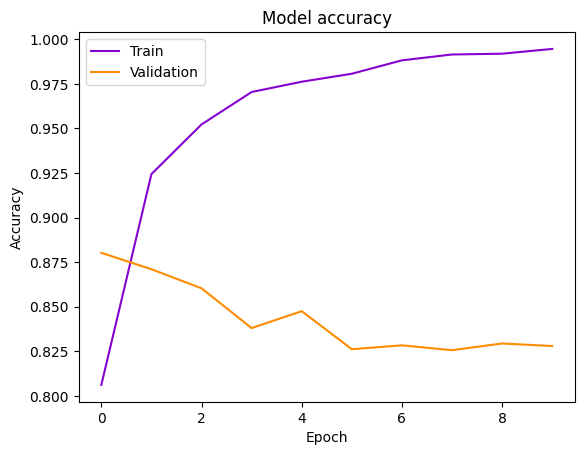

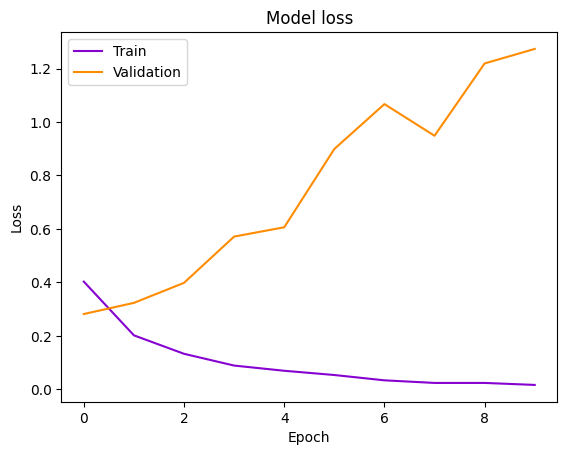

In [65]:
for i in evals['Metrics']:
    make_plot(i, history)

In [66]:
if Config.fine_tune:
    for i in evals['Metrics']:
        make_plot(i, history_finetune)

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Testing </h1>

In [67]:
def testing_plot(cmodel):
    pass


#testing_plot(tmodel)

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Wrong Predictions </h1>

In [68]:
def wrong_prediction():
  pass

#wrong_prediction()

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Inference </h1>

In [69]:
if Config.data_source == 'huggingface':
    text = ""


    inputs = tokenizer(text, return_tensors="tf")
    
    logits = tmodel(**inputs).logits

    predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
    display(tmodel.config.id2label[predicted_class_id])

In [70]:
if Config.data_source == 'tfds':
    binary_acc = model.evaluate(val_dataset)
    print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")
    
    
    # Create a model for inference.
    model_for_inference = models.Sequential([text_vectorizer, shallow_mlp_model])
    
    # Create a small dataset just for demoing inference.
    inference_dataset = make_dataset(test_df.sample(100), is_train=False)
    text_batch, label_batch = next(iter(inference_dataset))
    predicted_probabilities = model_for_inference.predict(text_batch)
    
    # Perform inference.
    for i, text in enumerate(text_batch[:5]):
        label = label_batch[i].numpy()[None, ...]
        print(f"Abstract: {text}")
        print(f"Label(s): {invert_multi_hot(label[0])}")
        predicted_proba = [proba for proba in predicted_probabilities[i]]
        top_3_labels = [
            x
            for _, x in sorted(
                zip(predicted_probabilities[i], lookup.get_vocabulary()),
                key=lambda pair: pair[0],
                reverse=True,
            )
        ][:3]
        print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
        print(" ")

In [71]:
def retesting():
    export_model = tf.keras.Sequential([
      vectorize_layer,
      tmodel,
      layers.Activation('sigmoid')
    ])
    
    export_model.compile(
        loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
    )
    
     
    metrics = export_model.evaluate(raw_test_ds, return_dict=True)
    print(metrics)

#retesting()

In [72]:
def revaluation(): 
    inputs = layers.Input(shape=(1,), dtype="string")
     
    indices = vectorize_layer(inputs)
     
    outputs = tmodel(indices)
    
     
    end_to_end_model = models.Model(inputs, outputs)
    end_to_end_model.compile(
        loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    
     
    end_to_end_model.evaluate(raw_test_ds, return_dict=True)

#revaluation()

In [73]:
def internal_infer(cmodel):

     examples = tf.constant([
      "The movie was great!",
      "The movie was okay.",
      "The movie was terrible..."
    ])
    
     predictions = cmodel.predict(examples)
     print(predictions)




In [75]:
# internal_infer(
#      export_model,
# )

In [76]:
def external_infer(cmodel, url):

   pass


# external_infer(
#     tmodel,
#     url='https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg'
# )

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Save Model and Weight </h1>

In [77]:
 def save_model_and_weight(cmodel):

    modelName = 'VGGModel'
    weight_path =  'weight'+modelName+".weights"+".h5"
    model_path = 'model'+modelName+".weights"+".keras"

    #model_json = cmodel.to_json()
    # with open(timestr+"_"+modelName+".json", "w") as json_file:
    #     json_file.write(model_json)

    #cmodel.save_weights(weight_path)
    #print('Weights Save Successfully')
    cmodel.save(model_path)
    print('Model Save Successfully')

    return weight_path, model_path

if Config.save_model:
    weight_path, model_path = save_model_and_weight(tmodel)

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Load Model and Weight </h1>

In [78]:
def general_load():
    # load json and create model
    json_file = open('20190107_220958_InceptionTutorial_MODEL_3.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)


    # load weights into new model
    model.load_weights("/kaggle/working/modelVGGModel.weights.keras")

#general_load()

In [79]:
def loading_model(export_path):

    reloaded = tf.keras.models.load_model(export_path)
    print('Model Loaded Successfully')
    return reloaded




#loaded_model =  loading_model(model_path)



In [80]:
# internal_infer(
#      loaded_model,
#      test_image_path= '/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Ipsala/Ipsala (1).jpg',
#      actual_label='Ipsala'
# )

In [81]:
def to_lite(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    with open('model.tflite', 'wb') as f:
      f.write(tflite_model)

    TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

    interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

        # Run a sample test with random input data
    input_shape = input_details[0]['shape']
    input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    # Output predictions
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print("Sample output from the TFLite model:", output_data)
    # interpreter.get_signature_list()

    # classify_lite = interpreter.get_signature_runner('serving_default')


    # predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
    # score_lite = tf.nn.softmax(predictions_lite)
    # print(
    #     "This image most likely belongs to {} with a {:.2f} percent confidence."
    #     .format(category[np.argmax(score_lite)], 100 * np.max(score_lite))
    # )

    #print(np.max(np.abs(predictions - predictions_lite)))

#to_lite(tmodel)

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:center;"> Misc </h1>

In [82]:
#from tensorflow.keras.applications.imagenet_utils import preprocess_input
#preprocess_input